In [1]:
import pyrootutils
import os

# Set the project root using the current working directory
project_root = pyrootutils.setup_root(os.getcwd(), indicator=".git", pythonpath=True, cwd=True)
print("Working directory set to:", os.getcwd())

Working directory set to: /home/ec2-user/embedding-adapter


In [2]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [3]:
import os
import torch
import pandas as pd

from lightning.pytorch import Trainer
from embedding_adapter.products_datamodule import TripletDataModule
from embedding_adapter.products_module import TripletModule

/home/ec2-user/embedding-adapter/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import hydra
from hydra.utils import instantiate

model_path = "logs/products/triplet_model_2025-05-15_11-46-03_503b0c"
hydra.initialize(config_path="../../" + model_path)

/tmp/ipykernel_2104503/287951822.py:5: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  hydra.initialize(config_path="../../" + model_path)


hydra.initialize()

In [5]:
cfg = hydra.compose(config_name=f"config.yaml")

# Load the trained model from checkpoint
checkpoint_path = f"{model_path}/checkpoints/triplet-model-best-ood-val.ckpt"

model = TripletModule.load_from_checkpoint(checkpoint_path, map_location=torch.device('cuda'))
model.eval()

# Initialize the data module
cfg.datamodule.batch_size = 256
datamodule: TripletDataModule = instantiate(cfg.datamodule)

# Initialize the trainer
trainer = Trainer(
    accelerator="gpu" if torch.cuda.is_available() else "cpu", 
    devices=1, 
    logger=False
)

# Run validation
results = trainer.predict(model, datamodule=datamodule)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA L4') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


Predicting DataLoader 2: 100%|██████████| 20/20 [00:00<00:00, 75.73it/s]  


In [6]:
model

TripletModule(
  (adapter): ConcatAdapter(
    (transform): Sequential(
      (0): RMSNorm((1024,), eps=None, elementwise_affine=False)
      (1): Linear(in_features=1024, out_features=1024, bias=True)
    )
    (adapter): Sequential(
      (0): Linear(in_features=2048, out_features=512, bias=True)
    )
  )
  (loss_fn): TripletLoss(
    (criterion): CrossEntropyLoss()
  )
  (in_batch_loss_fn): JointInfoNCELoss()
)

In [7]:
import torch

def collate_fn(batch):
    """
    Collates a list of dictionaries with tensor (or list) values into a single dictionary with tensor (or list) values.
    
    Args:
        batch (list): A list of dictionaries with tensor values.
    
    Returns:
        dict: A dictionary where each key corresponds to a stacked tensor of the values from the input dictionaries.
    """
    collated = {}
    for key in batch[0].keys():
        if isinstance(batch[0][key], torch.Tensor):
            collated[key] = torch.concat([item[key] for item in batch], axis=0)
        elif isinstance(batch[0][key], list):
            collated[key] = sum([item[key] for item in batch], [])
        else:
            raise TypeError(f"Unsupported data type for key '{key}': {type(batch[0][key])}")
    return collated

In [8]:
train_results = collate_fn(results[0])
val_results = collate_fn(results[1])
ood_results = collate_fn(results[2])

## Show Results

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from torch.nn.functional import cosine_similarity

In [10]:
def compute_similarities(data: dict):
    return {
        'positive_similarity': cosine_similarity(data['embedding_anchor'], data['embedding_positive'], dim=-1),
        'negative_similarity': cosine_similarity(data['embedding_anchor'], data['embedding_negative'], dim=-1),
        'adapted_positive_similarity': cosine_similarity(data['adapted_embedding_anchor'], data['adapted_embedding_positive'], dim=-1),
        'adapted_negative_similarity': cosine_similarity(data['adapted_embedding_anchor'], data['adapted_embedding_negative'], dim=-1),
    }

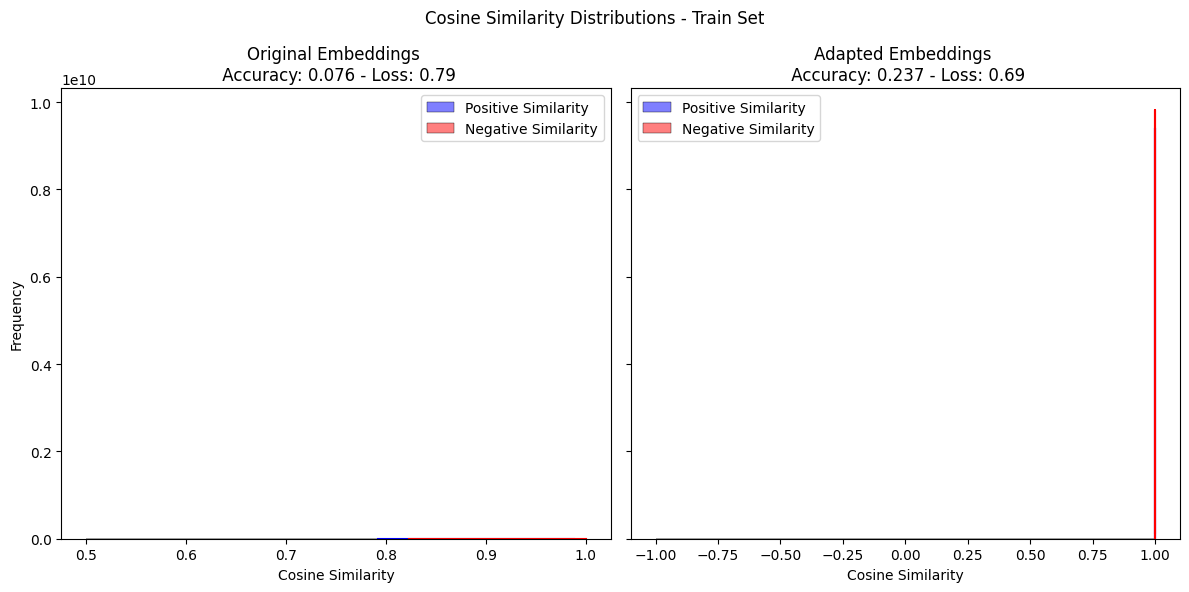

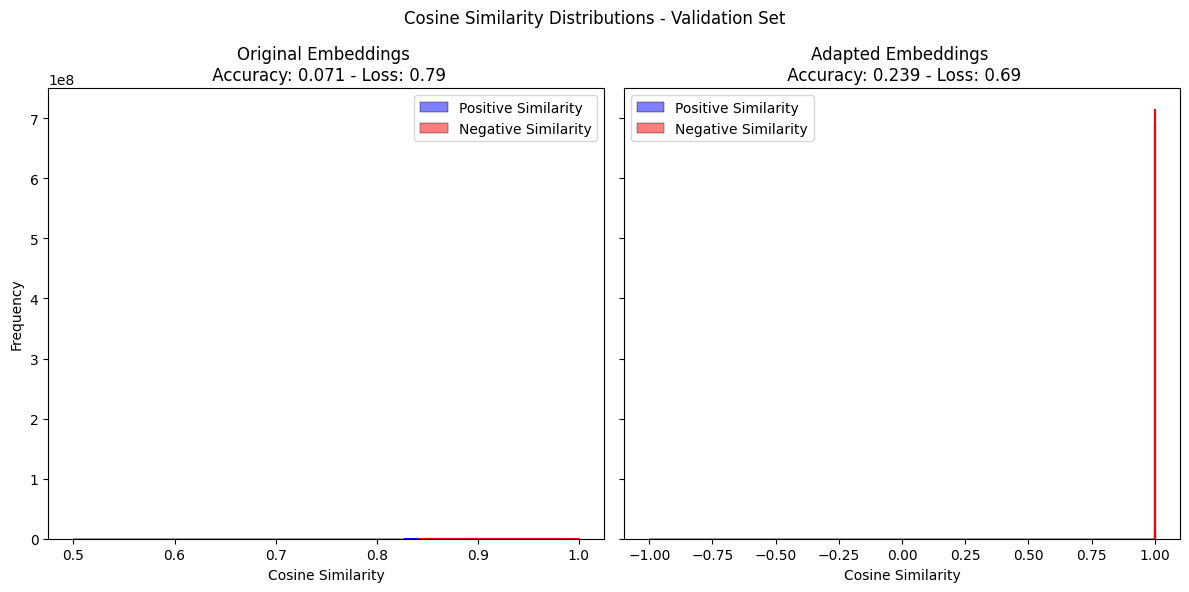

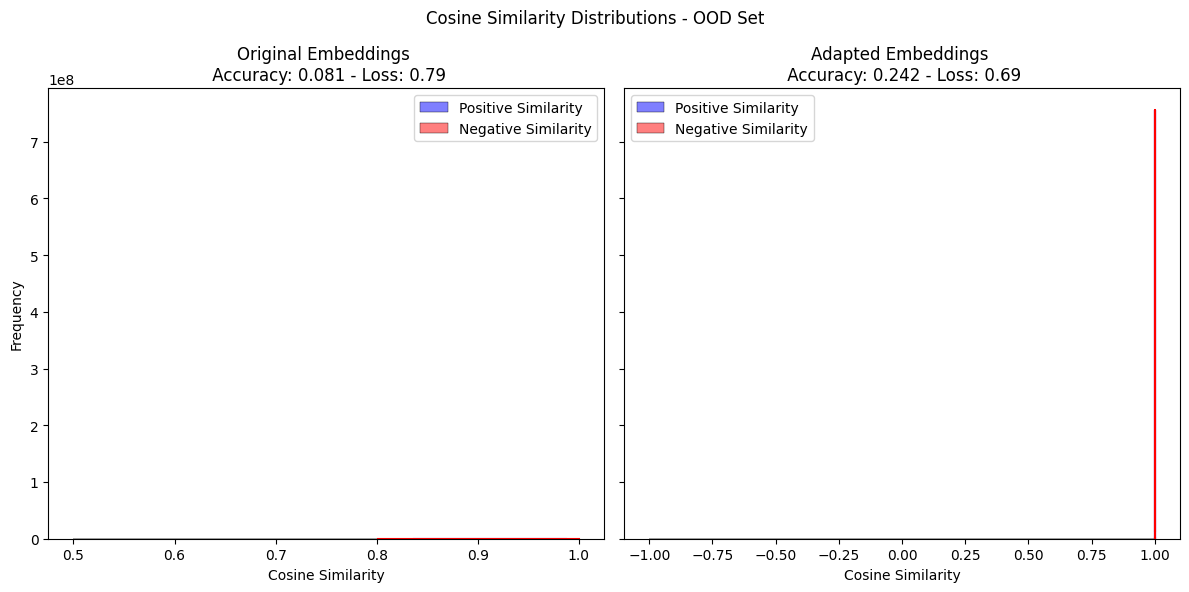

In [11]:
loss_fn = model.loss_fn

def plot_similarity_distributions(results, title="Cosine Similarity Distributions"):
    # Create a figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

    similarities = compute_similarities(results)

    # Plot the distributions for original embeddings
    sns.histplot(similarities['positive_similarity'].numpy(), binwidth=0.005, binrange=(0.5, 1), color='blue', label='Positive Similarity', kde=True, ax=axes[0])
    sns.histplot(similarities['negative_similarity'].numpy(), binwidth=0.005, binrange=(0.5, 1), color='red', label='Negative Similarity', kde=True, ax=axes[0])
    accuracy = torch.mean((similarities['positive_similarity'] > similarities['negative_similarity']).float()).item()
    loss = loss_fn(results['embedding_anchor'], results['embedding_positive'], results['embedding_negative'])
    axes[0].set_title(f'Original Embeddings \n Accuracy: {accuracy:.3f} - Loss: {loss:.2f}')
    axes[0].set_xlabel('Cosine Similarity')
    axes[0].set_ylabel('Frequency')
    axes[0].legend()

    # Plot the distributions for adapted embeddings
    sns.histplot(similarities['adapted_positive_similarity'].numpy(), binwidth=0.02, binrange=(-1, 1), color='blue', label='Positive Similarity', kde=True, ax=axes[1])
    sns.histplot(similarities['adapted_negative_similarity'].numpy(), binwidth=0.02, binrange=(-1, 1), color='red', label='Negative Similarity', kde=True, ax=axes[1])
    accuracy = torch.mean((similarities['adapted_positive_similarity'] > similarities['adapted_negative_similarity']).float()).item()
    loss = loss_fn(results['adapted_embedding_anchor'], results['adapted_embedding_positive'], results['adapted_embedding_negative'])
    axes[1].set_title(f'Adapted Embeddings \n Accuracy: {accuracy:.3f} - Loss: {loss:.2f}')
    axes[1].set_xlabel('Cosine Similarity')
    axes[1].legend()

    # Adjust layout
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

plot_similarity_distributions(train_results, title="Cosine Similarity Distributions - Train Set")
plot_similarity_distributions(val_results, title="Cosine Similarity Distributions - Validation Set")
plot_similarity_distributions(ood_results, title="Cosine Similarity Distributions - OOD Set")

In [12]:
def cosine_similarity_matrix(tensor1: torch.Tensor, tensor2: torch.Tensor) -> torch.Tensor:
    norm_tensor1 = tensor1 / tensor1.norm(dim=1, keepdim=True)
    norm_tensor2 = tensor2 / tensor2.norm(dim=1, keepdim=True)
    return torch.mm(norm_tensor1, norm_tensor2.t())

In [13]:
train_tasks = pd.DataFrame({
    'task': train_results['task'],
    'id_task': train_results['id_task'],
    'embedding_task': [row for row in train_results['embedding_task'].numpy()],
}).drop_duplicates(subset=['id_task']).reset_index(drop=True)

ood_tasks = pd.DataFrame({
    'task': ood_results['task'],
    'id_task': ood_results['id_task'],
    'embedding_task': [row for row in ood_results['embedding_task'].numpy()],
}).drop_duplicates(subset=['id_task']).reset_index(drop=True)

In [14]:
similarity_threshold = 0.9

train_task_embeddings = torch.Tensor(np.stack(train_tasks['embedding_task'].to_numpy()))
similarity_matrix = cosine_similarity_matrix(ood_results['embedding_task'], train_task_embeddings)

# Count the number of datapoints with similarity above the threshold for each embedding_context
similarity_counts = (similarity_matrix >= similarity_threshold).sum(dim=1)

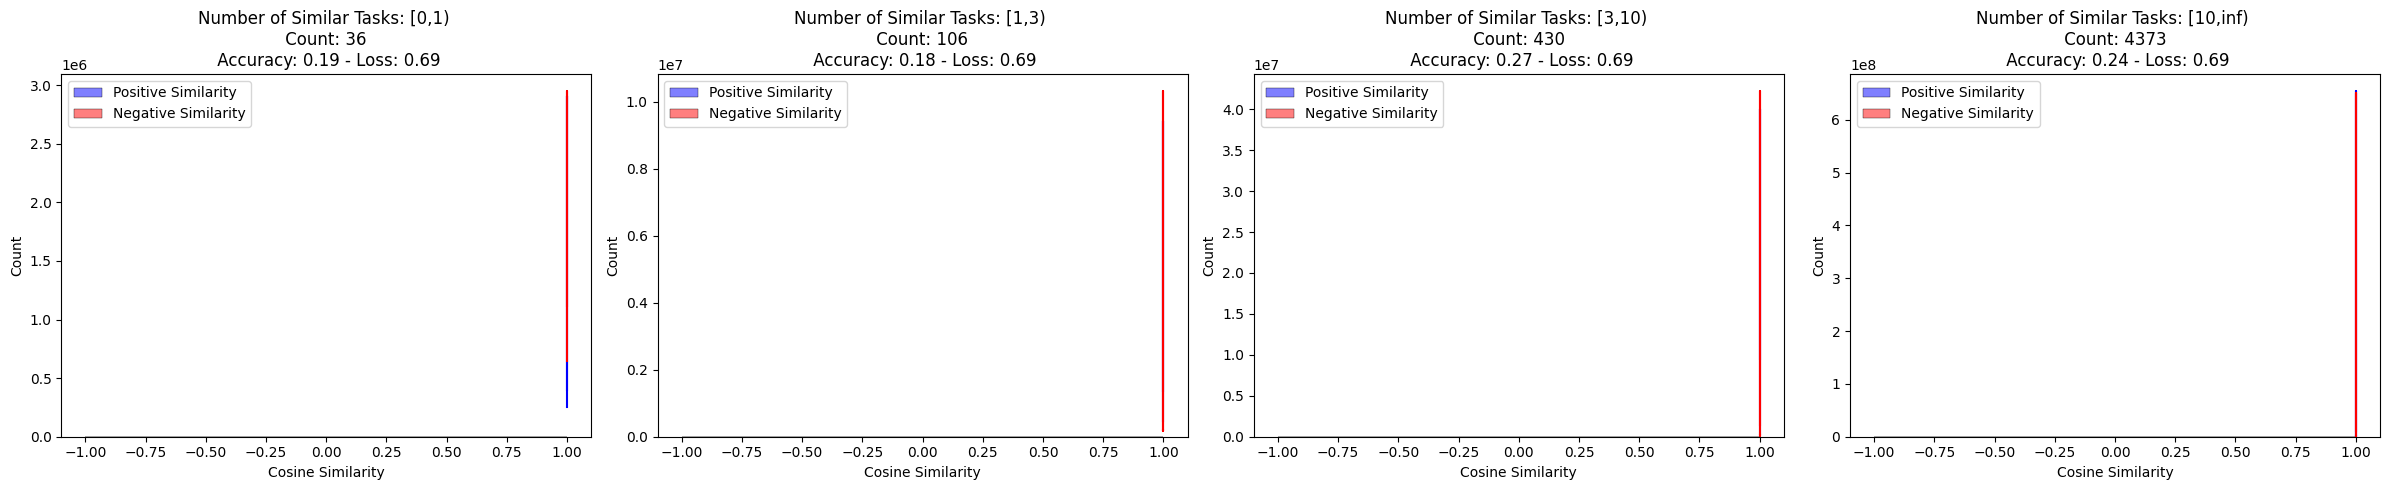

In [15]:
similarities = compute_similarities(ood_results)

ranges = [(0, 1), (1, 3), (3, 10), (10, np.inf)]
fig, axes = plt.subplots(1, len(ranges), figsize=(6 * len(ranges), 5))

for i, (low, high) in enumerate(ranges):
    indices = torch.where((similarity_counts >= low) & (similarity_counts < high))[0]
    sns.histplot(similarities['adapted_positive_similarity'][indices].numpy(), binwidth=0.02, binrange=(-1, 1), color='blue', label='Positive Similarity', kde=True, ax=axes[i])
    sns.histplot(similarities['adapted_negative_similarity'][indices].numpy(), binwidth=0.02, binrange=(-1, 1), color='red', label='Negative Similarity', kde=True, ax=axes[i])
    accuracy = torch.mean((similarities['adapted_positive_similarity'][indices] > similarities['adapted_negative_similarity'][indices]).float()).item()
    loss = loss_fn(ood_results['adapted_embedding_anchor'][indices], ood_results['adapted_embedding_positive'][indices], ood_results['adapted_embedding_negative'][indices])
    axes[i].set_title(f'Number of Similar Tasks: [{low},{high}) \n Count: {len(indices)} \n Accuracy: {accuracy:.2f} - Loss: {loss:.2f}')
    axes[i].set_xlabel('Cosine Similarity')
    axes[i].legend()

plt.tight_layout()
plt.show()